# The ARMA(p,q) model 

In [1]:
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

## Simulate an ARMA(1,1) process 

In [3]:
np.random.seed(42)

ar1 = np.array([1, -0.5])
ma1 = np.array([1, 0.5])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

### Test for stationarity 

In [4]:
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.863883907845347
p-value: 1.4235955093972001e-19


### Plot ACF 

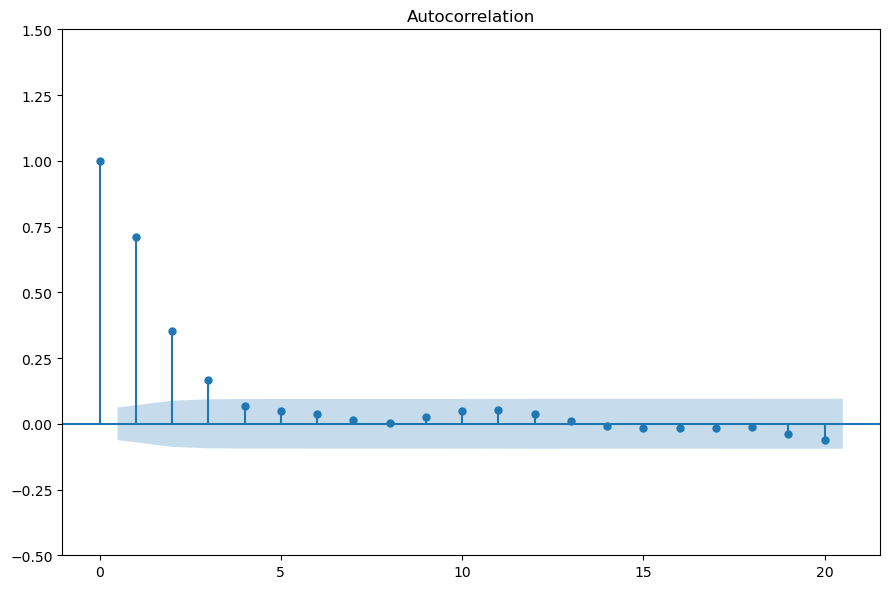

In [5]:
plot_acf(ARMA_1_1, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

## Plot PACF 

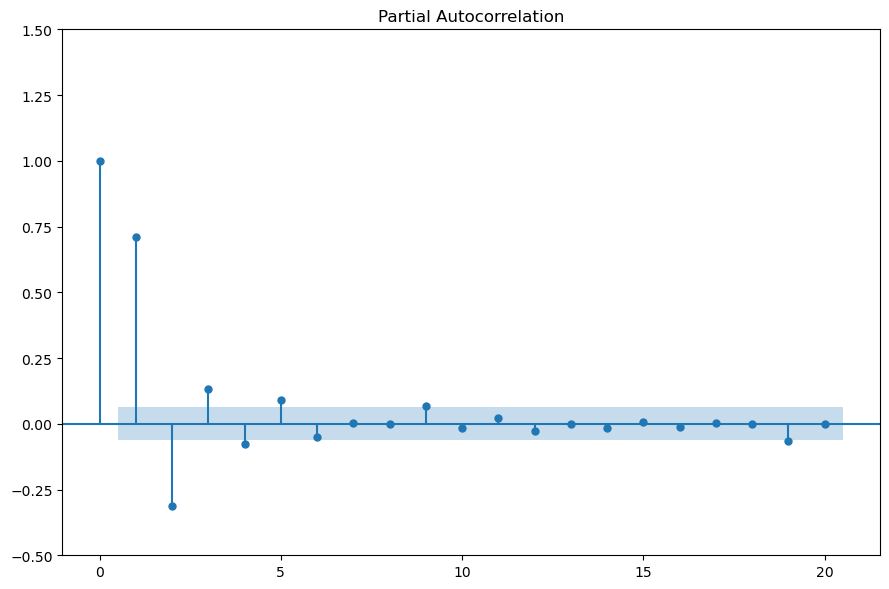

In [6]:
plot_pacf(ARMA_1_1, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

## Applying the general modeling procedure 

In [7]:
def ARMA_gridsearch(endog, min_p, max_p, min_q, max_q):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_p_q = list(product(all_p, all_q))
    
    print(f'Trying {len(all_p_q)} unique models')
    
    results = []
    
    for each in tqdm_notebook(all_p_q):
        try:
            model = SARIMAX(endog, order=(each[0], 0, each[1])).fit()
        except:
            continnue
            
        results.append([each, model.aic])
        
    order_df = pd.DataFrame(results)
    order_df.columns = ['(p,q)', 'AIC']
    
    order_df = order_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return order_df

In [8]:
order_df = ARMA_gridsearch(ARMA_1_1, 0, 3, 0, 3)
order_df

Trying 16 unique models


  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.952045
1,"(3, 1)",2801.964035
2,"(1, 3)",2801.971182
3,"(2, 1)",2803.047982
4,"(3, 3)",2803.143703
5,"(1, 2)",2803.363085
6,"(0, 3)",2803.428478
7,"(3, 2)",2803.835921
8,"(2, 3)",2803.852681
9,"(2, 2)",2805.842425


### Residuals analysis 

In [9]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

#### Q-Q plot 

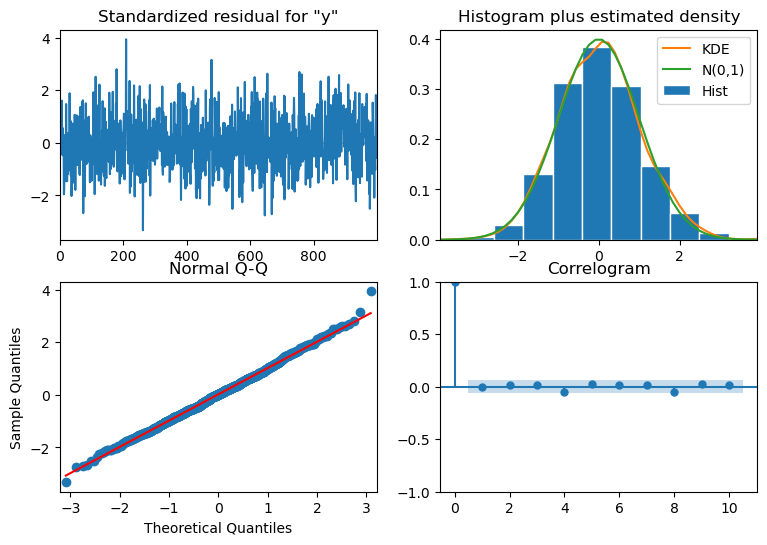

In [10]:
model_fit.plot_diagnostics();

#### Ljung-Box test 

In [11]:
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('One p-value is smaller than 0.05')

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


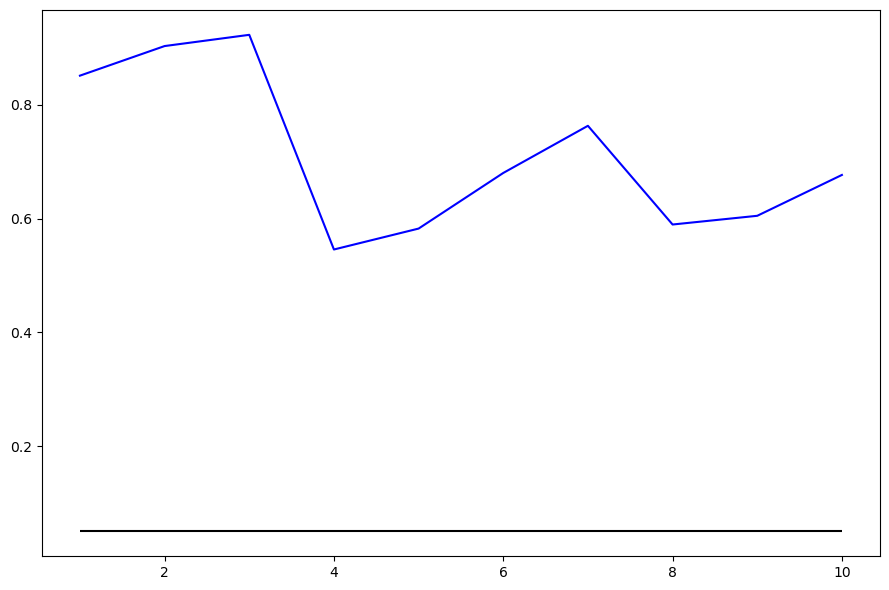

In [12]:
ljung_box_test(residuals, False, None)

## Forecasting with ARMA(p,q) 

In [13]:
df = pd.read_csv('data/simulated_ARMA.csv')
df.head()

,value
0,1000.000000
1,999.324822
2,998.505125
3,997.230597
4,995.889162


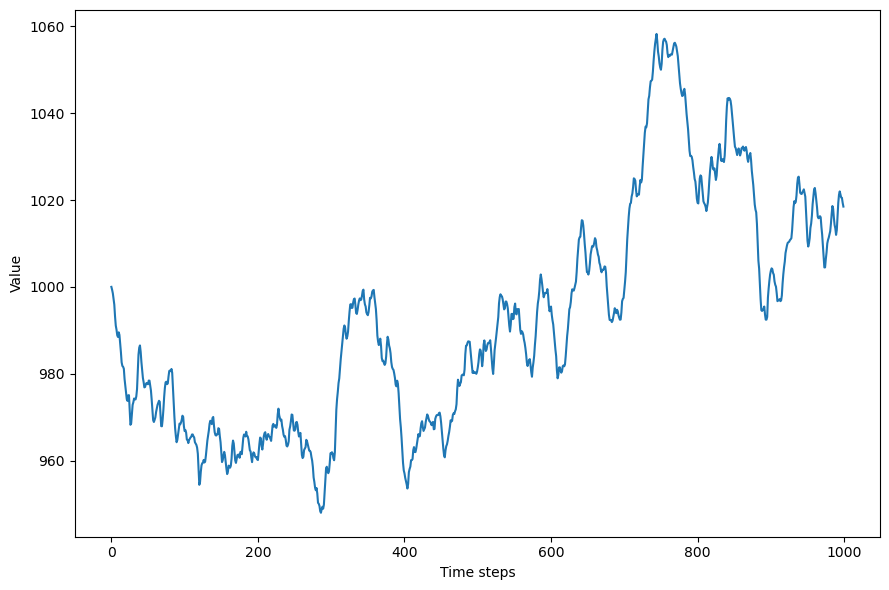

In [14]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

plt.tight_layout()

### General modeling procedure
#### Make the series stationary

In [15]:
ADF_result = adfuller(df['value'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.6867520717675288
p-value: 0.43795080886336396


In [16]:
series_diff = np.diff(df['value'], n=1)

In [17]:
ADF_result = adfuller(series_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.811194493659922
p-value: 1.9068174576523168e-19


#### Optional: plot ACF and PACF 

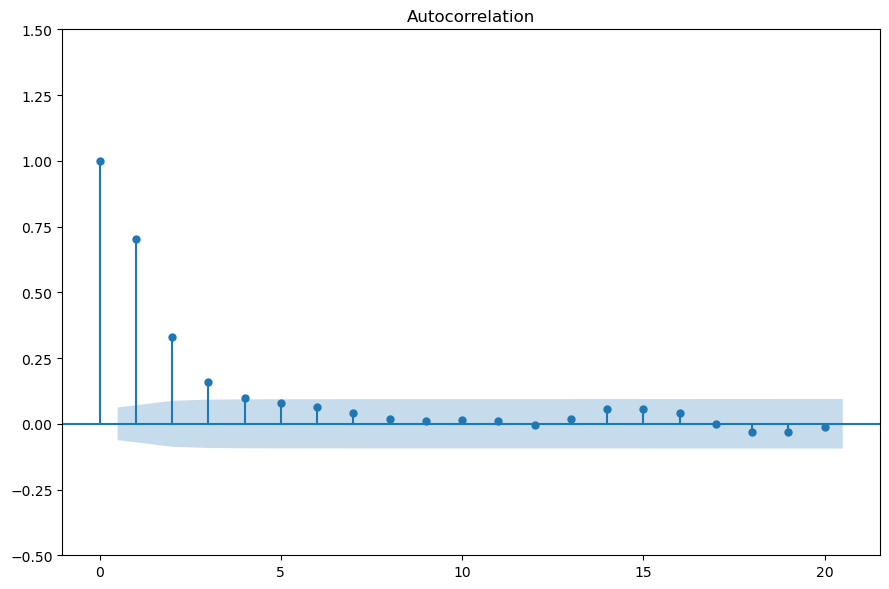

In [18]:
plot_acf(series_diff, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

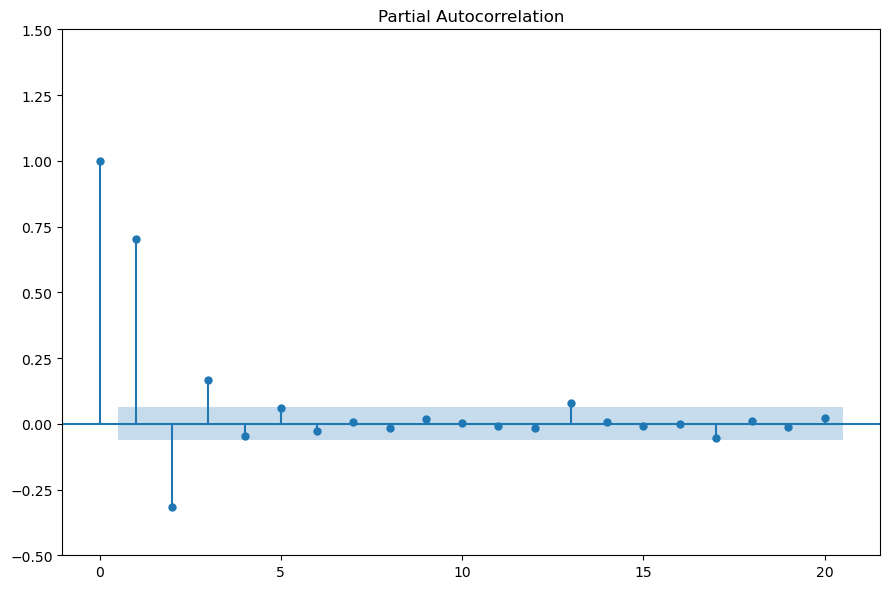

In [19]:
plot_pacf(series_diff, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

#### Train/test split 

In [20]:
df_diff = pd.DataFrame({'value_diff': series_diff})

train = df_diff[:-100]
test = df_diff[-100:]

print(len(train))
print(len(test))

899
100


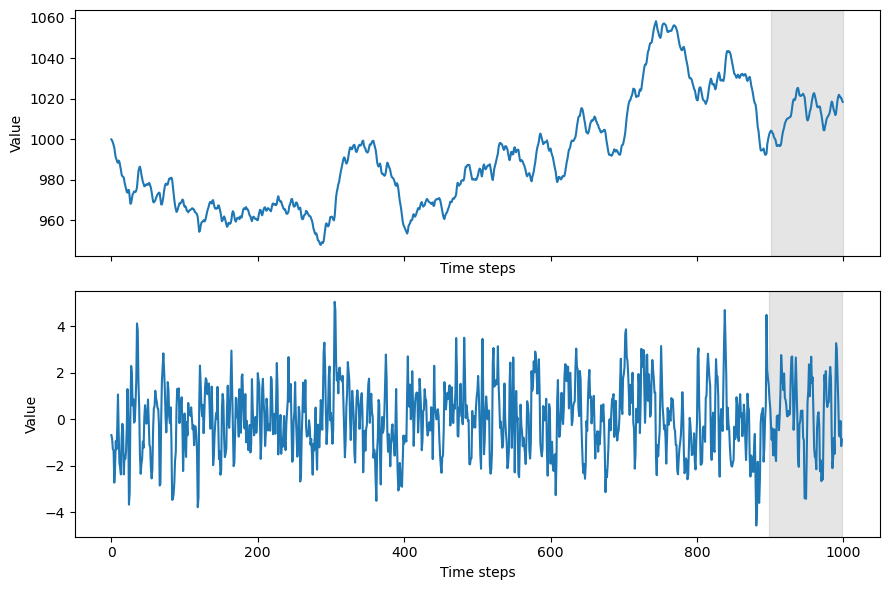

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['value'])
ax1.set_xlabel('Time steps')
ax1.set_ylabel('Value')
ax1.axvspan(901, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['value_diff'])
ax2.set_xlabel('Time steps')
ax2.set_ylabel('Value')
ax2.axvspan(899, 998, color='#808080', alpha=0.2)

plt.tight_layout()

In [22]:
def ARMA_gridsearch(endog, min_p, max_p, min_q, max_q):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_p_q = list(product(all_p, all_q))
    
    print(f'Trying {len(all_p_q)} unique models')
    
    results = []
    
    for each in tqdm_notebook(all_p_q):
        try:
            model = SARIMAX(endog, order=(each[0], 0, each[1])).fit()
        except:
            continnue
            
        results.append([each, model.aic])
        
    order_df = pd.DataFrame(results)
    order_df.columns = ['(p,q)', 'AIC']
    
    order_df = order_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return order_df

In [23]:
order_df = ARMA_gridsearch(train['value_diff'], 0, 3, 0, 3)
order_df.head()

Trying 16 unique models


  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2528.974670
1,"(3, 3)",2529.211228
2,"(1, 2)",2530.868637
3,"(2, 1)",2530.886127
4,"(2, 2)",2531.068118


In [24]:
model = SARIMAX(train['value_diff'], order=(1,0,1))
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             value_diff   No. Observations:                  899
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1261.487
Date:                Thu, 05 Jan 2023   AIC                           2528.975
Time:                        13:23:13   BIC                           2543.379
Sample:                             0   HQIC                          2534.477
                                - 899                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4510      0.039     11.458      0.000       0.374       0.528
ma.L1          0.5389      0.035     15.275      0.000       0.470       0.608
sigma2         0.9679      0.044     21.800      0.0

#### Residuals analysis 

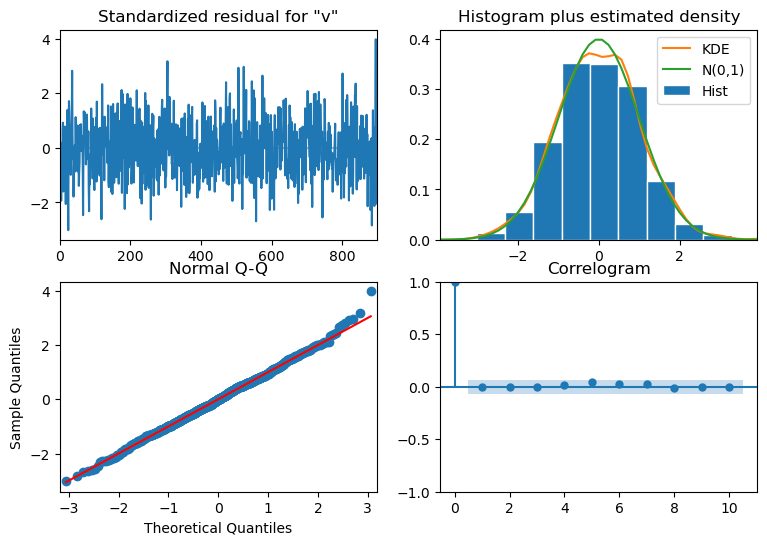

In [25]:
model_fit.plot_diagnostics();

In [26]:
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('One p-value is smaller than 0.05')

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


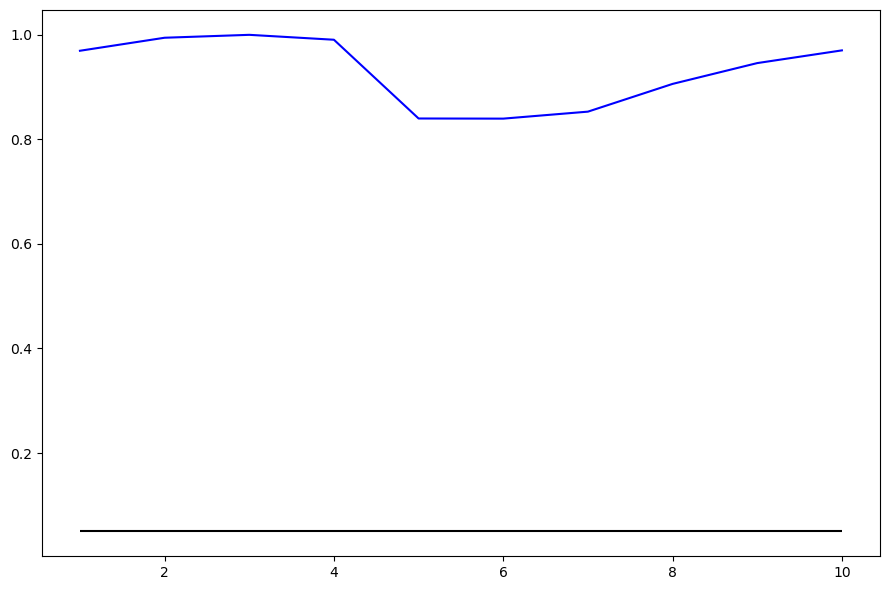

In [27]:
residuals = model_fit.resid

ljung_box_test(residuals, False, None)

#### Forecasting 

In [28]:
def rolling_predictions(df_diff: pd.DataFrame, last_train_value: np.array, train_len: int, horizon: int, window: int, method: str) -> list:
    
    TOTAL_LEN = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(df_diff[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        pred_mean = np.concatenate((last_train_value, pred_mean))
        pred_mean = pred_mean.cumsum()
        
        return pred_mean[:100]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_value = df_diff[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        pred_last_value = np.concatenate((last_train_value, pred_last_value))
        pred_last_value = pred_last_value.cumsum()
        
        return pred_last_value[:100]
    
    if method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df_diff[:i], order=(1,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        pred_ARMA = np.concatenate((last_train_value, pred_ARMA))
        pred_ARMA = pred_ARMA.cumsum()
            
        return pred_ARMA[:100]

In [29]:
pred_df = df[-100:].copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = df.iloc[899].values

windows = [1, 2, 5, 10]

for window in windows:
    pred_mean = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'mean')
    pred_last = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'last')
    pred_ARMA = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'ARMA')

    pred_df[f'pred_mean_{window}'] = pred_mean
    pred_df[f'pred_last_{window}'] = pred_last
    pred_df[f'pred_ARMA_{window}'] = pred_ARMA

pred_df.head()

,value,pred_mean_1,pred_last_1,pred_ARMA_1,pred_mean_2,pred_last_2,pred_ARMA_2,pred_mean_5,pred_last_5,pred_ARMA_5,pred_mean_10,pred_last_10,pred_ARMA_10
900,1003.730386,1002.863325,1002.863325,1002.863325,1002.863325,1002.863325,1002.863325,1002.863325,1002.863325,1002.863325,1002.863325,1002.863325,1002.863325
901,1004.262068,1002.866510,1004.310236,1003.328221,1002.866510,1004.310236,1003.328221,1002.866510,1004.310236,1003.328221,1002.866510,1004.310236,1003.328221
902,1004.080917,1002.870654,1005.177297,1003.934114,1002.869695,1005.757148,1003.537886,1002.869695,1005.757148,1003.537886,1002.869695,1005.757148,1003.537886
903,1003.208391,1002.875385,1005.708980,1004.134752,1002.874425,1006.288831,1003.738525,1002.872880,1007.204060,1003.632444,1002.872880,1007.204060,1003.632444
904,1002.816720,1002.879909,1005.527829,1003.847927,1002.879155,1006.820514,1003.829245,1002.876065,1008.650972,1003.675089,1002.876065,1008.650972,1003.675089


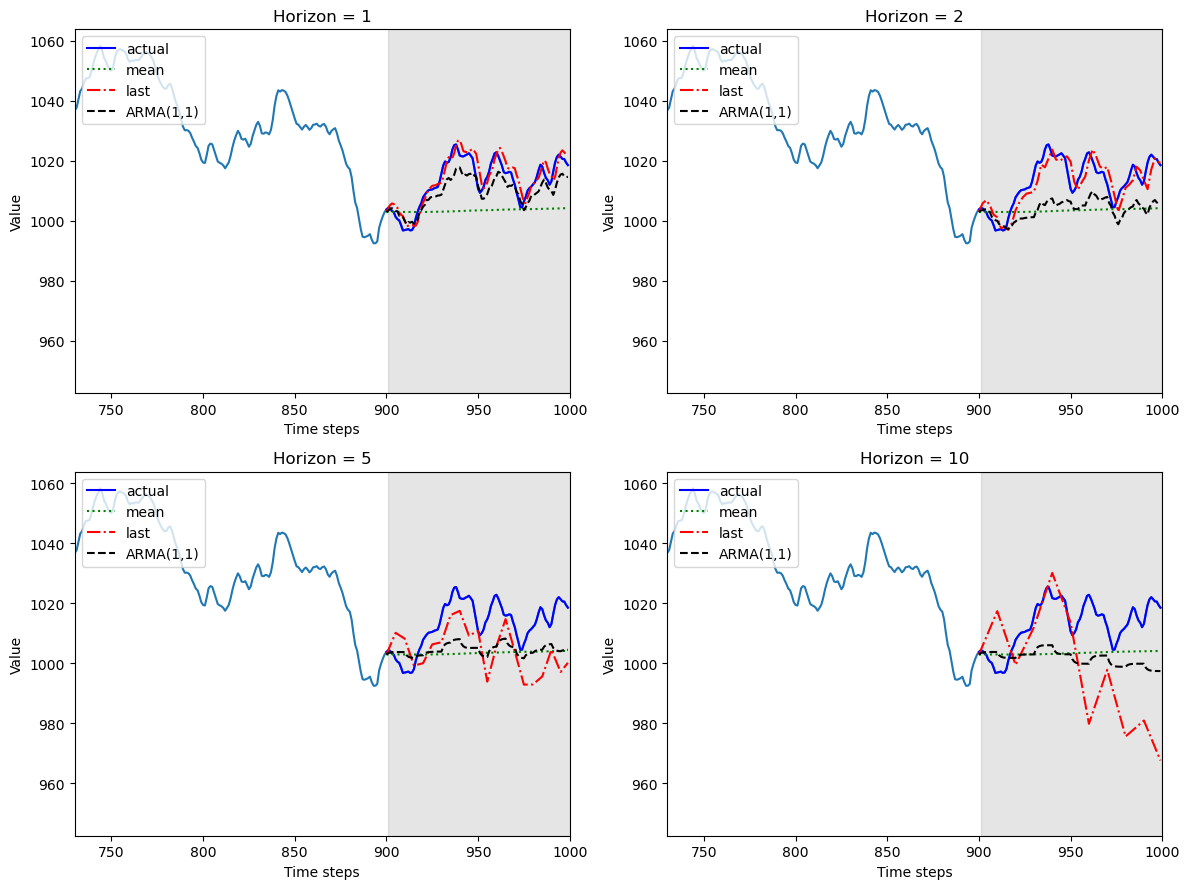

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['value'])
    ax.plot(pred_df['value'], 'b-', label='actual')
    ax.plot(pred_df[f'pred_mean_{windows[i]}'], 'g:', label='mean')
    ax.plot(pred_df[f'pred_last_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'pred_ARMA_{windows[i]}'], 'k--', label='ARMA(1,1)')
    
    ax.legend(loc=2)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.axvspan(901, 1000, color='#808080', alpha=0.2)
    ax.set_xlim(730, 1000)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()

In [31]:
mae_mean_1 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_1'])
mae_last_1 = mean_absolute_error(pred_df['value'], pred_df['pred_last_1'])
mae_ARMA_1 = mean_absolute_error(pred_df['value'], pred_df['pred_ARMA_1'])

mae_mean_2 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_2'])
mae_last_2 = mean_absolute_error(pred_df['value'], pred_df['pred_last_2'])
mae_ARMA_2 = mean_absolute_error(pred_df['value'], pred_df['pred_ARMA_2'])

mae_mean_5 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_5'])
mae_last_5 = mean_absolute_error(pred_df['value'], pred_df['pred_last_5'])
mae_ARMA_5 = mean_absolute_error(pred_df['value'], pred_df['pred_ARMA_5'])

mae_mean_10 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_10'])
mae_last_10 = mean_absolute_error(pred_df['value'], pred_df['pred_last_10'])
mae_ARMA_10 = mean_absolute_error(pred_df['value'], pred_df['pred_ARMA_10'])

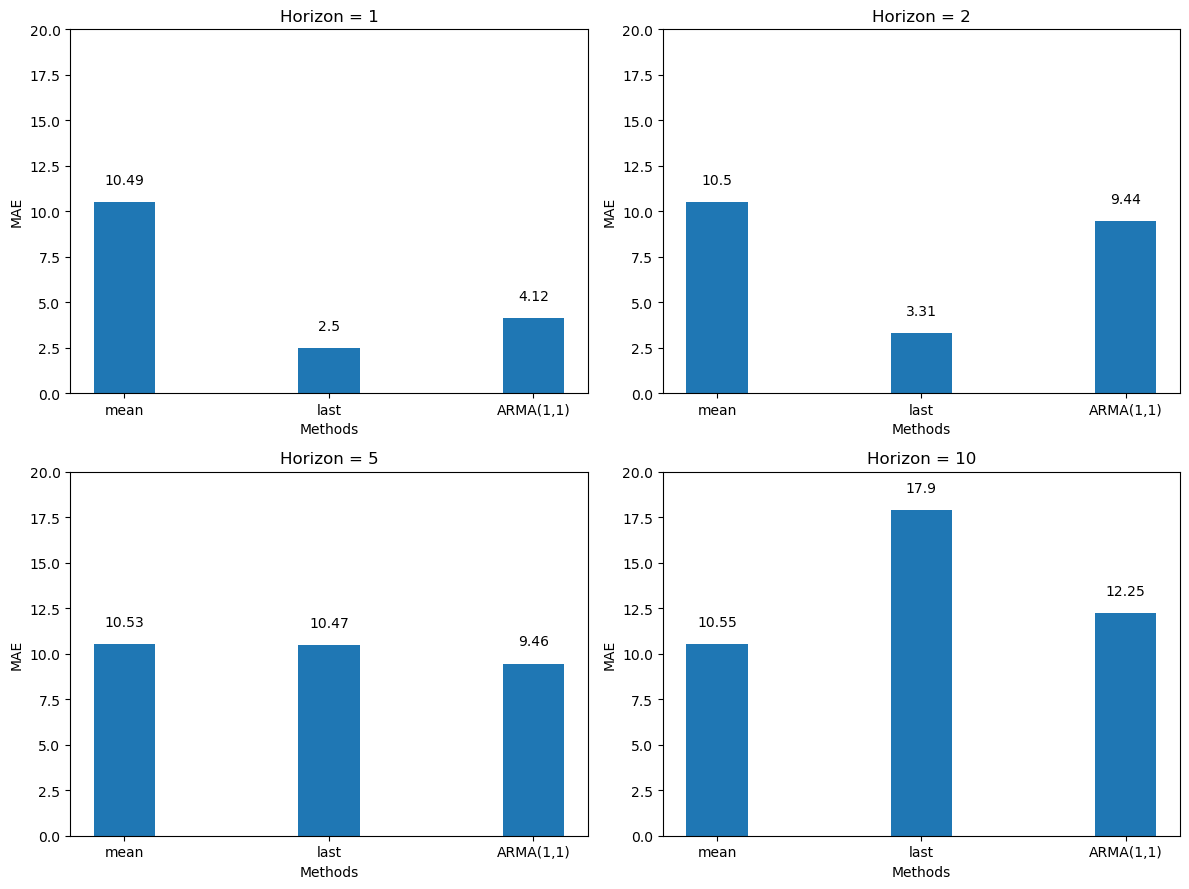

In [32]:
maes_mean = [mae_mean_1, mae_mean_2, mae_mean_5, mae_mean_10]
maes_last = [mae_last_1, mae_last_2, mae_last_5, mae_last_10]
maes_ARMA = [mae_ARMA_1, mae_ARMA_2, mae_ARMA_5, mae_ARMA_10]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

x = ['mean', 'last', 'ARMA(1,1)']
width = 0.3

for i, ax in enumerate(axes.flatten()):
    
    y = [maes_mean[i], maes_last[i], maes_ARMA[i]]
    ax.bar(x, y, width)
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAE')
    ax.set_ylim(0, 20)
    ax.set_title(f'Horizon = {windows[i]}')    
    
    for index, value in enumerate(y):
        ax.text(x=index, y=value+1, s=str(round(value, 2)), ha='center')

plt.tight_layout()